In [1]:
# PyTorch is a common library for neural networks in Python. torch.nn is a module for building layers of Neural Networks.
import torch
from torch import nn
import torch.nn.functional as F

# TorchVision is part of the PyTorch environment. It is necessary to download the datasets MNIST (and EMNIST Letters)
import torchvision
import torchvision.transforms as transforms

# Usual mathematical stuff
import numpy as np
import math
# Plots
import matplotlib.pyplot as plt

# Timing
import time
from datetime import datetime
import time

# additional packages
import torchvision.utils as vutils
# from torchviz import make_dot

In [2]:
# Check if GPU is available

def chooseDevice():
    device = ""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("GPU available via cuda")
    else:
        device = torch.device("cpu")
        print("GPU not available, CPU available")
    return device

In [3]:
device = chooseDevice()

GPU not available, CPU available


In [4]:
_ = torch.manual_seed(2472)

In [12]:
# Extracts the train and test sets from a chosen image dataset
# Values of pixels are normalized between -1 and 1
def getData(dataset = "MNIST", info = True):
    if dataset == "MNIST":
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
        train_set = torchvision.datasets.MNIST(root=".", train=True, download=True, transform=transform)
        test_set = torchvision.datasets.MNIST(root=".", train=False, download=True, transform=transform)
    elif dataset == "EMNIST_Letters":
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
        train_set = torchvision.datasets.EMNIST(root=".", split="letters", train=True, download=True, transform=transform)
        test_set = torchvision.datasets.EMNIST(root=".", split="letters", train=False, download=True, transform=transform)
    else:
        print("DATASET NOT CORRECTLY DEFINED")
    if info:
        print(train_set)
        print(test_set)
    return train_set, test_set

In [13]:
# Choose which dataset to use

dataset = "MNIST"
#dataset = "EMNIST_Letters"

train_set, test_set = getData(dataset = dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: .
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [14]:
# Get information about the size of the train and test sets.

def dataSize(train_set, test_set):
    n_train_set = train_set.__len__()
    n_test_set = test_set.__len__()
    n_tot = n_train_set + n_test_set
    ratio_train_test = n_train_set / n_test_set
    percentage_train = n_train_set / n_tot
    percentage_test = 1.0 - percentage_train
    return n_train_set, n_test_set, n_tot, ratio_train_test, percentage_train, percentage_test

In [15]:
n_train_set, n_test_set, n_tot, ratio_train_test, percentage_train, percentage_test = dataSize(train_set, test_set)

In [16]:
# Divide dataset into batches

def divideInBatches(train_set, test_set, batch_size, n_train_set, n_test_set):
    # Train set
    n_batches_total = math.ceil(n_train_set/batch_size)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

    # Test set
    n_batches_total_test = math.ceil(n_test_set/batch_size)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

    return train_loader, test_loader, n_batches_total, n_batches_total_test

In [17]:
# Corrects EMNIST Letters data

def correctData(real_samples, mnist_labels, dataset):
    if dataset == "EMNIST_Letters":
        real_samples = torch.transpose(real_samples,2,3)
        mnist_labels -= 1
    return real_samples, mnist_labels

In [18]:
# Plot digits or letters

def showImages(samples, true_labels = None, predicted_labels = None, generated = False, predicted = False, epoch = None):

    if generated == True and predicted == True:
        plt.close("Generated predicted samples")
        f = plt.figure("Generated predicted samples", figsize = (20,15))
        f.suptitle("Generated predicted samples", fontsize = 30)
    elif generated == True and predicted == False :
        if epoch != None:
            plt.close("Generated samples epoch " + str(epoch))
            f = plt.figure("Generated samples epoch " + str(epoch), figsize = (20,15))
            f.suptitle("Generated samples epoch " + str(epoch), fontsize = 30)
        else:
            plt.close("Generated samples")
            f = plt.figure("Generated samples", figsize = (20,15))
            f.suptitle("Generated samples", fontsize = 30)
    elif predicted == True and generated == False :
        if epoch != None:
            plt.close("Predicted samples epoch " + str(epoch))
            f = plt.figure("Predicted samples epoch " + str(epoch), figsize = (20,15))
            f.suptitle("Predicted samples epoch " + str(epoch), fontsize = 30)
        else:
            plt.close("Predicted samples")
            f = plt.figure("Predicted samples", figsize = (20,15))
            f.suptitle("Predicted samples", fontsize = 30)
    else:
        plt.close("MNIST samples")
        f = plt.figure("MNIST samples", figsize = (20,15))
        f.suptitle("MNIST training samples", fontsize = 30)
    f.subplots_adjust(wspace=0.2, hspace=0.4)
    plt.rc('axes', titlesize=20)

    for i in range(16):
        if i < samples.size(0):
            if generated:
                a = samples[i][0].detach().numpy()
            else:
                a = samples[i]
            fi = f.add_subplot(4, 4, i + 1)
            fi.imshow(a.reshape(28, 28), cmap="gray_r")
            plt.xticks([])
            plt.yticks([])
            if generated == True and predicted == True :
                fi.title.set_text("Pred: " + str(predicted_labels[i].detach().numpy()))
            elif generated == True and predicted == False :
                fi.title.set_text("Sample " + str(i))
            elif predicted == True and generated == False :
                fi.title.set_text("Pred: " + str(predicted_labels[i].detach().numpy()) +  ", true: " + str(true_labels[i].detach().numpy()))
            else:
                fi.title.set_text("Sample " + str(i) + ": " + str(true_labels[i].detach().numpy()))

    now = datetime.now().strftime("%Y_%m_%d__%H_%M_%S")
    if generated == True and predicted == True :
        f.savefig('./Figures/Sample_generated__' + now + '__epoch_' + str(epoch) + '.svg')
    elif generated == True and predicted == False :
        f.savefig('./Figures/Sample_generated_predicted__' + now + '__epoch_' + str(epoch) + '.svg')
    elif predicted == True and generated == False :
        f.savefig('./Figures/Sample_predicted__' + now + '__epoch_' + str(epoch) + '.svg')
    else:
        f.savefig('./Figures/Sample_MNIST.svg')

In [19]:

def computeGANAccuracy(y_predicted,y_true):

    accuracy = torch.sum((y_predicted>0) == y_true) / len(y_true)

    return accuracy

In [20]:
def generate_latent_vectors(dim_latent_space, batch_size):
    # generate latent vectors based on a standard normal distribution
    latent_vectors = torch.randn(dim_latent_space * batch_size).reshape(batch_size, dim_latent_space)

    return latent_vectors

In [21]:
def loadModel(model, model_name, date_time):
    model.load_state_dict(torch.load('./Models/' + model_name ))
    model.eval()
    return model

In [22]:
def numberClasses(dataset):
    n_classes = len(dataset.classes)
    return n_classes

In [23]:
def plot_cnn_prediction(classifier, data_loader, min=0, max=5):
    for i, data in enumerate(data_loader, 0):
        if i in range(min, max):
            X = data[0].to(device)
            y_true = data[1].to(device)
            result = classifier(X)
            y_hat = classifier.predictLabels(result)[0]
            print("Saving Images: %d" % (i+1))
            showImages(X, true_labels=y_true, predicted_labels=y_hat, predicted=True)

In [24]:
class Generator(nn.Module):

    def __init__(self, dim_latent_space):
        super().__init__()
        self.dim_latent_space = dim_latent_space
        self.fc = nn.Linear(self.dim_latent_space, 64*7*7)
        self.trans_conv1 = nn.ConvTranspose2d(64, 64, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.trans_conv2 = nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 1, padding = 1)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.trans_conv3 = nn.ConvTranspose2d(32, 16, kernel_size = 3, stride = 1, padding = 1)
        self.batch_norm3 = nn.BatchNorm2d(16)
        self.trans_conv4 = nn.ConvTranspose2d(16, 1, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)

    def forward(self, x):                   # Input = batch_size*dim_latent_space
        x = self.fc(x)                      # Output = batch_size*(64*7*7)
        x = x.view(-1, 64, 7, 7)            # Output = batch_size*64*7*7
        x = self.trans_conv1(x)             # Output = batch_size*64*14*14
        x = F.relu(self.batch_norm1(x))
        x = self.trans_conv2(x)             # Output = batch_size*32*14*14
        x = F.relu(self.batch_norm2(x))
        x = self.trans_conv3(x)             # Output = batch_size*16*14*14
        x = F.relu(self.batch_norm3(x))
        x = self.trans_conv4(x)             # Output = batch_size*1*28*28
        x = torch.tanh(x)
        return x

class Discriminator(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(1, 32, kernel_size = 3, stride = 2, padding = 1)
        self.conv0_drop = nn.Dropout2d(0.25)
        self.conv1 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv1_drop = nn.Dropout2d(0.25)
        self.conv2 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_drop = nn.Dropout2d(0.25)
        self.conv3 = nn.Conv2d(128, 128, kernel_size = 3, stride = 2, padding = 1)
        self.conv3_drop = nn.Dropout2d(0.25)
        self.fc = nn.Linear(128*7*7, 1)

    def forward(self, x):                               # Input = batch_size*1*28*28
        x = x.view(-1, 1, 28, 28)                       # Output = batch_size*1*28*28
        x = F.leaky_relu(self.conv0(x), 0.2)            # Output = batch_size*32*14*14
        x = self.conv0_drop(x)
        x = F.leaky_relu(self.conv1(x), 0.2)            # Output = batch_size*64*14*14
        x = self.conv1_drop(x)
        x = F.leaky_relu(self.conv2(x), 0.2)            # Output = batch_size*128*14*14
        x = self.conv2_drop(x)
        x = F.leaky_relu(self.conv3(x), 0.2)            # Output = batch_size*128*7*7
        x = self.conv3_drop(x)
        x = x.view(-1, 128*7*7)                         # Output = batch_size*(128*7*7)
        x = self.fc(x)                                  # Output = batch_size*1
        return x
class CNN(nn.Module):
    def __init__(self, n_classes):
        super(CNN, self).__init__()
        self.n_classes = n_classes
        self.conv1 = nn.Sequential(             # Images input is batch_size*1*28*28
            nn.Conv2d(1, 16, 5, 1, 2),          # Output is batch_size*16*28*28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),        # Output is batch_size*16*14*14
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),         # Output is batch_size*32*14*14
            nn.ReLU(),
            nn.MaxPool2d(2),                    # Output is batch_size*32*7*7
        )
        # fully connected layer, output one number for each class
        self.out = nn.Sequential(
            nn.Linear(32 * 7 * 7, self.n_classes),          # Output is batch_size*n_classes
        )

    def scaleToProbabilities(self, outmap, scale_factor = 3):
        # scale_factor allows to scale your output before passing it into the softmax function
        # in order to get numbers interpratble as probabilities

        flattened_outmap = outmap.view(outmap.shape[0], -1)
        outmap_std = torch.std(flattened_outmap, dim = 1).view(-1, 1)
        outmap_scaled_std = torch.div(outmap, outmap_std)
        probabilities = nn.functional.softmax(outmap_scaled_std*scale_factor, dim=1)
        return probabilities

    def predictLabels(self, outmap, scale_factor = 3):
        probabilities = self.scaleToProbabilities(outmap, scale_factor = 3)
        certainty, predicted_labels = torch.max(probabilities, 1)
        predicted_labels = predicted_labels.data.squeeze()
        certainty = certainty.data.squeeze()
        return predicted_labels, probabilities, certainty

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), 32 * 7 * 7)
        output = self.out(x)
        return output

In [25]:
#now we pass rlvs_lot through the image generator
#print(rlvs_lot)--> i just wanted to check it, ignore it
# Paramater for the batch size
# Predefined value = 32

n_classes = numberClasses(train_set)



dim_latent_space = 100
batch_size = 32
nb_batches = 200



date_time = ""
genname = "gen5"
disname = "dis5"
cnnname = "cnn_5_epochs"

generator = Generator(dim_latent_space)
discriminator = Discriminator()
cnn = CNN(n_classes)

#loading the generator, discriminator and cnn model (classifier)
generator =  loadModel(generator, genname, date_time)
discriminator = loadModel(discriminator, disname, date_time)
cnn = loadModel(cnn, cnnname, date_time)



generator.eval()
discriminator.eval()
cnn.eval()


CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Sequential(
    (0): Linear(in_features=1568, out_features=10, bias=True)
  )
)

In [26]:
def generate_triplets(dim_latent_space=dim_latent_space ,batch_size=batch_size ,nb_batches=nb_batches, generate_latent_vectors=generate_latent_vectors, generator=generator, cnn=cnn):
    list_lat_vec = []
    list_images = []
    list_cnn = []


    for i in range(nb_batches):
      # make batch_size*nb_batches triplets with the output of cnn
      list_lat_vec.append(generate_latent_vectors(dim_latent_space, batch_size))
      list_images.append(generator(list_lat_vec[i]))
      list_cnn.append(cnn(list_images[i]))

    return list_lat_vec, list_images, list_cnn

## Section 4

### 4.1 Open message

You are asked to generate one list of digits/letters that will represent one message. Therefore, you have to find corresponding latent vectors that we call the ”message latent vectors” and put them, in order, in a PyTorch tensor. Then, you have to save it in a file thanks to the saveLatentVectors function provided below. You can also load previously saved latent vectors with loadLatentVectors.

In [32]:
def generate_triplets(dim_latent_space=dim_latent_space ,batch_size=batch_size ,nb_batches=nb_batches, generate_latent_vectors=generate_latent_vectors, generator=generator, cnn=cnn):
    list_lat_vec = []
    list_images = []
    list_cnn = []


    for i in range(nb_batches):
      # make batch_size*nb_batches triplets with the output of cnn
      list_lat_vec.append(generate_latent_vectors(dim_latent_space, batch_size))
      list_images.append(generator(list_lat_vec[i]))
      list_cnn.append(cnn(list_images[i]))

    return list_lat_vec, list_images, list_cnn

def keep_above_threshold(list_lat_vec, list_images, list_cnn, thresh, generator=generator, cnn=cnn, n_classes=n_classes):
    flist_lat_vec = []
    flist_images = []
    flist_cnn = []

    nb_batches = len(list_lat_vec)
    batch_size = len(list_lat_vec[0])


    nbnb0 = np.zeros(n_classes)
    nbnb = np.zeros(n_classes)

    for i in range(nb_batches):
      #  if certainty bigger that the threshold, save the triplet with the label

      prob = cnn.predictLabels(list_cnn[i])
      # print((prob))
      for j in range(batch_size):

        # with no threshold
        nbnb0[prob[0][j].item()] += 1


        # with threshold=thresh
        if prob[2][j].item()> thresh:
          flist_lat_vec.append(list_lat_vec[i][j])
          flist_images.append(list_images[i][j])
          flist_cnn.append(prob[0][j].item())
          nbnb[flist_cnn[-1]] +=1

    return flist_lat_vec, flist_images, flist_cnn, nbnb, nbnb0

def devide_in_label(flist_lat_vec, flist_cnn, n_classes=n_classes, cnn=cnn):
    #adding each labelled latent vector to its corresponding class

    vector_list_label = [[] for i in range(n_classes)]

    nb_vecs = len(flist_lat_vec)

    for i in range(nb_vecs):
        lab = flist_cnn[i]
        vector_list_label[lab].append(flist_lat_vec[i])
    return vector_list_label

def compute_mean_label(vector_list_label):
    n_classes = len(vector_list_label)
    mean_label = [[] for i in range (n_classes)]

    for i in range(n_classes):
        mean = torch.mean(torch.stack(vector_list_label[i]), 0) #calculating the mean of these mean latent vectors
        mean_label[i] = mean
    return mean_label

In [34]:
thresh = 0.9

list_lat_vec, list_images, list_cnn = generate_triplets(nb_batches = nb_batches)
flist_lat_vec, flist_images, flist_cnn, nbnb, nbnb0= keep_above_threshold(list_lat_vec, list_images, list_cnn, thresh)
vector_list_label = devide_in_label(flist_lat_vec, flist_cnn)
mean_label = compute_mean_label(vector_list_label)

In [37]:
a = generator(torch.stack(mean_label))

In [59]:
def saveLatentVectors(filename , latent_vectors ):
    torch.save(latent_vectors , './Latent_Vectors/' + filename)
    return

In [60]:
def loadLatentVectors(filename):
    latent_vectors = torch.load('./Latent_Vectors/' + filename)
    return latent_vectors

In [62]:
saveLatentVectors("numerical_latent_vectors", a)

In [72]:
numerical_latent_vectors = loadLatentVectors('numerical_latent_vectors')

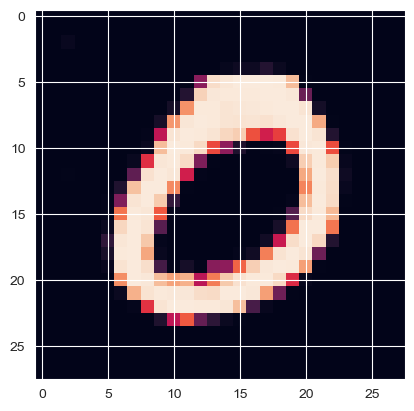

In [66]:
plt.figure()
plt.imshow(a[0][0].detach().numpy())
plt.show()

In [104]:
def show_message(message, latenet_vectors, meaning):
    latent_vectors_list = []

    numerical_list = [*message]

    n_cols = 4
    n_rows = int(np.ceil(len(numerical_list)/4))
    f = plt.figure("Messages", figsize = (20,15))
    f.suptitle(meaning, fontsize = 30)
    f.subplots_adjust(wspace=0.2, hspace=0.2)
    j = 0
    for i in numerical_list:
        latent_vectors_list.append(latenet_vectors[eval(i)][0])
        fi = f.add_subplot(n_rows, n_cols, j + 1)
        fi.imshow(latenet_vectors[eval(i)][0].detach().numpy(), cmap="gray_r")
        plt.xticks([])
        plt.yticks([])

        j += 1
    plt.show()
    f.savefig('./Figures/' + meaning + '.png')

    saveLatentVectors(meaning, torch.stack(latent_vectors_list))

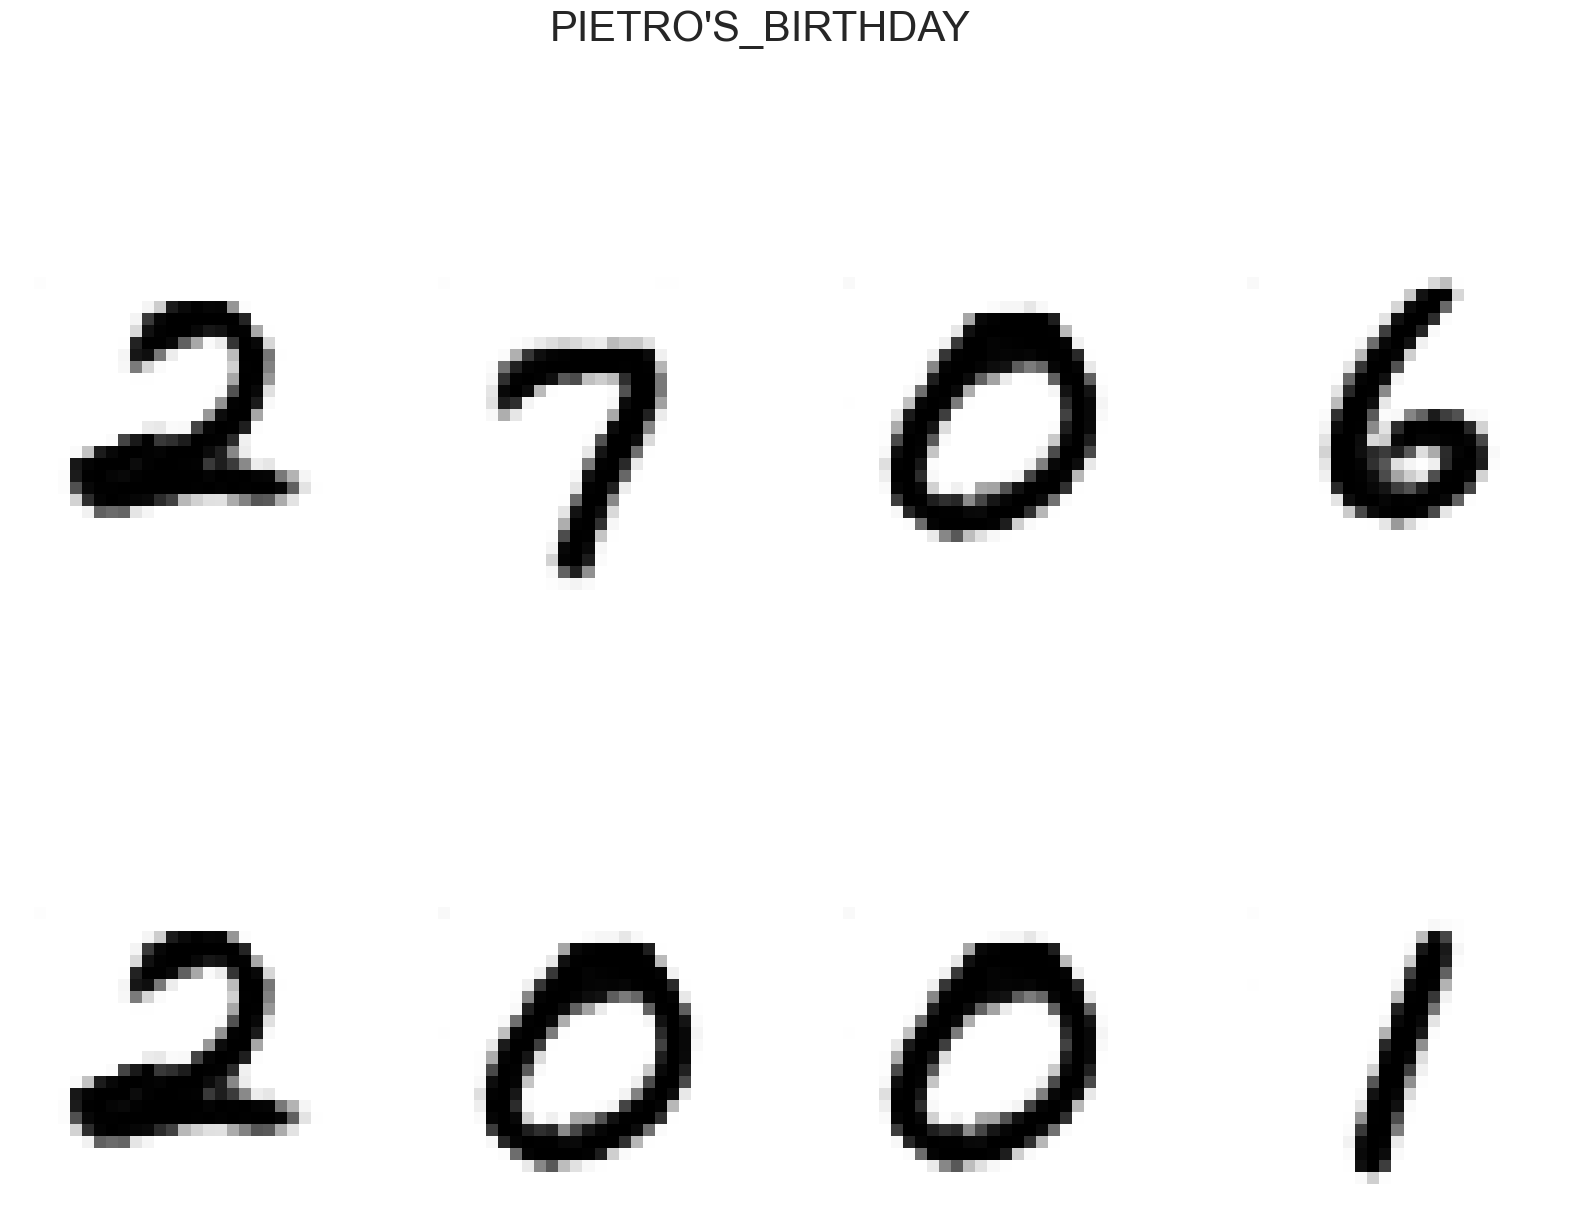

In [105]:
show_message("27062001", numerical_latent_vectors, "PIETRO\'S_BIRTHDAY")